In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

xls = pd.ExcelFile('Glossary.xls')
xls.sheet_names

Using TensorFlow backend.


['Glossary', 'alternative_tag', 'subject_type']

In [2]:
df = xls.parse('Glossary')
df = df[(df['language'] == 'eng') & (df['subject_id'] != 0)]
print(df.head(5))

   language  subject_id                 keyword simplified_definition  \
34      eng          20      "De facto" concept                   NaN   
36      eng          20       "De jure" concept                   NaN   
38      eng          20  Child dependency ratio                   NaN   
40      eng          20        Crude birth rate                   NaN   
42      eng          20        Crude death rate                   NaN   

                                    detail_definition  
34  Under a "de facto" concept, the population inc...  
36  Under a "de jure" concept, all persons who usu...  
38  Child dependency ratio refers to the number of...  
40  Crude birth rate refers to the number of live ...  
42  Crude death rate refers to the number of death...  


In [3]:
subject_df = xls.parse('subject_type')
subject_df = subject_df.set_index('subject_id')
print(subject_df.head(5))

            id       chi_name  \
subject_id                      
10           1  官方統計綜合報告及參考資料   
20           2             人口   
30           3             勞工   
40           4           對外貿易   
50           5    國民收入及國際收支平衡   

                                                     eng_name  
subject_id                                                     
10          General Reports and References in Official Sta...  
20                                                 Population  
30                                                     Labour  
40                                             External Trade  
50                    National Income and Balance of Payments  


In [4]:
df['subject'] = df['subject_id'].apply(lambda x: subject_df.loc[x]['eng_name'])
print(df.head(5))

   language  subject_id                 keyword simplified_definition  \
34      eng          20      "De facto" concept                   NaN   
36      eng          20       "De jure" concept                   NaN   
38      eng          20  Child dependency ratio                   NaN   
40      eng          20        Crude birth rate                   NaN   
42      eng          20        Crude death rate                   NaN   

                                    detail_definition     subject  
34  Under a "de facto" concept, the population inc...  Population  
36  Under a "de jure" concept, all persons who usu...  Population  
38  Child dependency ratio refers to the number of...  Population  
40  Crude birth rate refers to the number of live ...  Population  
42  Crude death rate refers to the number of death...  Population  


In [5]:
df['subject'].describe()

count                711
unique                33
top       2016 By-census
freq                  65
Name: subject, dtype: object

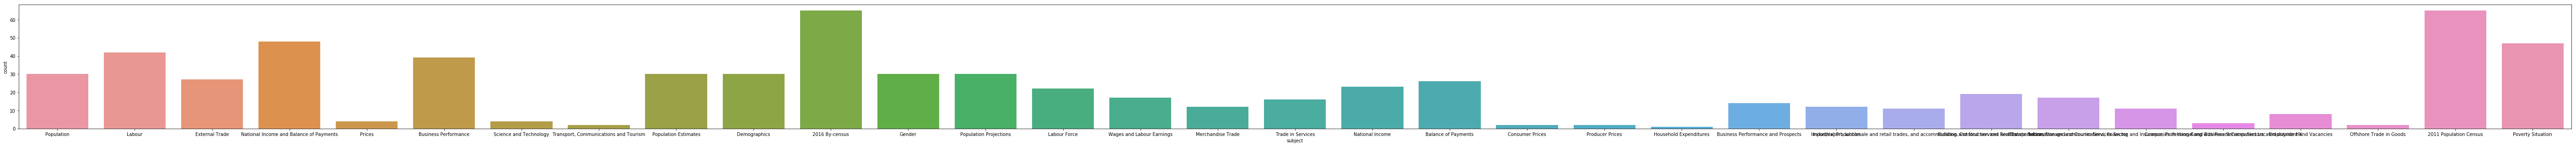

In [6]:
plt.rcParams['figure.figsize'] = (100.0, 5.0)
sns.countplot(df['subject'])

In [7]:
df['keyword'].describe()

count               711
unique              342
top       Establishment
freq                  9
Name: keyword, dtype: object

In [8]:
train_def = df['detail_definition'].values[:-5]
train_key = df['keyword'].values[:-5]

# due to the lack of data, I'm just going to use data from train to test
test_def = [train_def[-5]]
test_key = [train_key[-5]]

In [9]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [10]:
tokenize.fit_on_texts(train_def) # only fit on train
x_train = tokenize.texts_to_matrix(train_def)
x_test = tokenize.texts_to_matrix(test_def)

In [11]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_key)
y_train = encoder.transform(train_key)
y_test = encoder.transform(test_key)

In [12]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [13]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (706, 1000)
x_test shape: (1, 1000)
y_train shape: (706, 337)
y_test shape: (1, 337)


In [14]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [15]:
model.fit(x_train, y_train,
          batch_size=10,
          epochs=10,
          verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
706/706 [==============================] - 1s 1ms/step - loss: 5.4007 - acc: 0.1473
Epoch 2/10
706/706 [==============================] - 1s 1ms/step - loss: 3.1755 - acc: 0.5467
Epoch 3/10
706/706 [==============================] - 1s 1ms/step - loss: 1.6120 - acc: 0.7337
Epoch 4/10
706/706 [==============================] - 1s 1ms/step - loss: 0.9310 - acc: 0.8272
Epoch 5/10
706/706 [==============================] - 1s 1ms/step - loss: 0.6683 - acc: 0.8499
Epoch 6/10
706/706 [==============================] - 1s 1ms/step - loss: 0.5018 - acc: 0.8669
Epoch 7/10
706/706 [==============================] - 1s 1ms/step - loss: 0.4133 - acc: 0.8796
Epoch 8/10
706/706 [==============================] - 1s 1ms/step - loss: 0.4059 - acc: 0.8739
Epoch 9/10
706/706 [==============================] - 1s 1ms/step - loss: 0.3328 - acc: 0.9037
Epoch 10/10
706/706 [==============================

In [16]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=25, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

1/1 [==============================] - 0s 39ms/step
Test score: 0.0005303239449858665
Test accuracy: 1.0


In [17]:
def label_predict(string):
    text_labels = encoder.classes_ 
    test_matrix = tokenize.texts_to_matrix([string])
    prediction = model.predict(np.array([test_matrix[0]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(f'You entered: {string}')
    print("Predicted label: " + predicted_label + "\n")

In [18]:
label_predict('This is a population test')

You entered: This is a population test
Predicted label: Per capita GNI



In [20]:
label_predict("de facto")

You entered: de facto
Predicted label: "De facto" concept

